In [2]:
using PyPlot

In [3]:
using LsqFit

In [4]:
#Angle between line connecting center of planet to where edge of planet meets edge of star
#and the line connecting planet center to star center
alpha(r::Float64,k::Float64,l::Float64) = acos((r^2.0 + k^2.0 - l^2.0)/(2.0*k*r))    

alpha (generic function with 1 method)

In [5]:
#Angle between line connecting centers of planet and star and line connecting center of star to
#where edge of planet meets edge of star
beta2(r::Float64,k::Float64,l::Float64) = acos((r^2.0 + l^2.0 - k^2.0)/(2.0*l*r))  

beta2 (generic function with 1 method)

In [6]:
#projected distance between center of planet and star 
function r(tau::Array{Float64},b::Float64,k::Float64,l::Float64,T::Float64)
    v = 2.0*sqrt((k+l)^2.0-b^2.0)/T
    return sqrt(b^2.0 .+ (v.*tau).^2.0)
end

r (generic function with 1 method)

In [7]:
#Time before/after center of transit, modulo the period
tau(t::Array{Float64},P::Float64,t_n::Float64) = mod(t.-t_n+(P/2),P)-(P/2.0)

tau (generic function with 1 method)

In [8]:
#Overlapping area of two circles of radius k (planet) and l (star)
function overlap(rs::Array{Float64},k::Float64,l::Float64)
    result = Float64[]
    for r in rs
        if r >= l+k
            push!(result,0.0)
        elseif r <= l-k
            push!(result,pi*k^2.0)
        else
            push!(result,(k^2.0)*(alpha(r,k,l)-cos(alpha(r,k,l))*sin(alpha(r,k,l)))+(l^2.0)*(beta2(r,k,l)-cos(beta2(r,k,l))*sin(beta2(r,k,l))))
        end
    end
    return result
end

overlap (generic function with 1 method)

In [9]:
#Computes the transit depth as a function of time
function transit(ts::Array{Float64},params::Array{Float64})
    #params is [F_s,k,l,P,T,t_n,b]
    taus = tau(ts,params[4],params[6])
    rs = r(taus,params[7],params[2],params[3],params[5])
    overlaps = overlap(rs,params[2],params[3])
    return params[1]*(1.0.-overlaps./(pi*params[3]^2.0))
end

transit (generic function with 1 method)

In [10]:
#Can be used for secondary occultation if desired (requires an extra parameter)
function occultation(ts::Array{Float64},params::Array{Float64})
    #params is [F_p,k,l,P,T,t_n,b]
    taus = tau(ts-(params[4]/2.0),params[4],params[6])
    rs = r(taus,params[7],params[2],params[3],params[5])
    overlaps = overlap(rs,params[2],params[3])
    return params[1]*(1.0.-overlaps./(pi*params[2]^2.0))
end

occultation (generic function with 1 method)

In [11]:
# First guess at period, accurate to within 1 day
function transit_P_guess_init(x_data::Array{Float64},y_data::Array{Float64})
    arr = hcat(x_data,y_data)
    lowest = sortrows(arr, by=x->(x[2])) #sort all points by increasing flux
    mins = sort(unique(round(lowest[1:50,1]))) #take the dimmest 50 points, sort by time rounded
    return maximum(diff(mins)) 
end

transit_P_guess_init (generic function with 1 method)

In [12]:
#First guess for the time of transit, assume its the time of minimum flux
transit_tn_guess_init(x_data::Array{Float64},y_data::Array{Float64}) = x_data[findmin(y_data)[2]]

transit_tn_guess_init (generic function with 1 method)

In [13]:
#Now let's search around our initial period guess, phase fold the data, and search for the period 
#such that we minimize the mean value of the measured flux around the center of the transit
function transit_P_guess(x_data::Array{Float64},y_data::Array{Float64},P_guess::Float64,t_n::Float64)
    #period guess will be to the nearest day. Let's make an array of 100 points between the nearest two days
    P_arr = linspace(P_guess-1,P_guess+1,100)
    mean_arr = Float64[]
    for P in P_arr
        phases = (tau(x_data,P,t_n)/P)+0.5
        push!(mean_arr,mean(y_data[0.495.<=phases.<=0.505]))
    end
    return P_arr[mean_arr.==minimum(mean_arr)][1]
end

transit_P_guess (generic function with 1 method)

In [14]:
# Now that we have a much better period, take the median phase of the 75 faintest points, find 
# offset from the center of transit, and adjust the center of transit time accordingly
function transit_tn_guess(x_data::Array{Float64},y_data::Array{Float64},P::Float64,t_n::Float64)
    phases = (tau(x_data,P,t_n)/P)+0.5
    y_low = sort(y_data)[1:75]
    return t_n+(median(phases[findin(y_low,y_data)])-0.5)*P
end

transit_tn_guess (generic function with 1 method)

In [15]:
#determines a best guess for star flux
transit_Fs_guess(y_data::Array{Float64}) = median(round(y_data))

transit_Fs_guess (generic function with 1 method)

In [16]:
#Assume l~R_sun. Calculate a rough transit depth, which gives ratio of radii squared.
#This will give an underestimate for when b>l-k (planet disk never fully overlaps the star)
function transit_k_guess(y_data::Array{Float64},F_s::Float64)
    l = 6.96e10
    ysort = sort(y_data)
    depth_guess = 1.0 - median(ysort[1:100])/F_s
    return sqrt(depth_guess)*l
end

transit_k_guess (generic function with 1 method)

In [17]:
#Guess the transit duration by starting at the center of transit, and moving outward til the
#mean of the three nearest points starts to stabilize around the best fit star flux
function transit_T_guess(x_data::Array{Float64},y_data::Array{Float64},t_i::Float64,F_s::Float64)
    i_init = find(x_data .== t_i)[1]
    i = i_init
    av = 0.0
    while (F_s - av) >= 0.0015*F_s
        av = mean([y_data[i-1];y_data[i];y_data[i+1]])
        i += 1
    end
    return 2.0*(x_data[i]-x_data[i_init])
end

transit_T_guess (generic function with 1 method)

In [18]:
#Fit function just wraps up all of the guesses and then fits, returns a fit object.
#to get params, simply do result = fit_transit(x_data,y_data,y_err) then result.param
function fit_transit(x_data::Array{Float64},y_data::Array{Float64},y_err::Array{Float64})
    l_guess = 6.96e10
    P_guess_init = transit_P_guess_init(x_data,y_data)
    tn_guess_init = transit_tn_guess_init(x_data,y_data)
    P_guess = transit_P_guess(x_data,y_data,P_guess_init,tn_guess_init)
    tn_guess = transit_tn_guess(x_data,y_data,P_guess,tn_guess_init)
    F_guess = transit_Fs_guess(y_data)
    k_guess = transit_k_guess(y_data,F_guess)
    T_guess = transit_T_guess(x_data,y_data,tn_guess_init,F_guess)
    offset = (tn_guess-tn_guess_init)/tn_guess
    p0 = [F_guess,k_guess,l_guess,P_guess,T_guess,tn_guess_init+abs(offset),0.0]
    fit = curve_fit(transit,x_data,y_data,(1.0./y_err).^2.0,p0)
    return fit
end

fit_transit (generic function with 1 method)

In [19]:
#Read in data, separate into arrays
data = readdlm("mystery_planet2.txt",Float64) 
times = data[:,1]
flux0 = data[:,2]
flux = flux0/maximum(flux0)
flux_err = data[:,3] ;

In [31]:
@time result = fit_transit(times,flux0,flux_err) ;

  0.161920 seconds (608.00 k allocations: 105.203 MB, 8.32% gc time)


In [32]:
#fit_transit is pretty heavy on memory allocation. Seems like the most time is spent by curve_fit
#and by the sorting...
@profile result = fit_transit(times,flux0,flux_err) ;
Profile.print() ;

82 task.jl; anonymous; line: 447
 82 ...4/IJulia/src/IJulia.jl; eventloop; line: 141
  82 ...rc/execute_request.jl; execute_request_0x535c5df2; line: 177
   82 loading.jl; include_string; line: 282
    81 profile.jl; anonymous; line: 16
     43 In[18]; fit_transit; line: 3
      43 In[11]; transit_P_guess_init; line: 5
       43 sort.jl; sortrows; line: 504
        43 sort.jl; sort!; line: 402
         12 sort.jl; sort!; line: 293
          8 sort.jl; partition!; line: 277
           8 ordering.jl; lt; line: 55
            7 In[11]; anonymous; line: 5
             5 subarray.jl; getindex; line: 543
          4 sort.jl; partition!; line: 278
           1 ordering.jl; lt; line: 54
           2 ordering.jl; lt; line: 55
            1 In[11]; anonymous; line: 5
         9  sort.jl; sort!; line: 298
          4 sort.jl; sort!; line: 293
           2 sort.jl; partition!; line: 277
            2 ordering.jl; lt; line: 55
             2 In[11]; anonymous; line: 5
           2 sort.jl; partitio

In [33]:
function plot_transit(x_data::Array{Float64},y_data::Array{Float64},fit::LsqFit.LsqFitResult{Float64})
    #Outputs a phase folded normalized plot of light curve (points) with best fit (line)
    params = fit.param
    P = params[4]
    t_n = params[6]
    T = params[5]
    F0 = params[1]
    norm_flux = y_data/F0
    y_fit = transit(x_data,params)/F0
    phases = (tau(x_data,P,t_n)/P)+0.5
    
    v = sortperm(phases)   
    scatter(phases[v], norm_flux[v], color = "k", alpha=0.2)
    plot(phases[v],y_fit[v],"-r") 
    xlim(0.5-(1.5*T/P),0.5+(1.5*T/P));
end

plot_transit (generic function with 1 method)

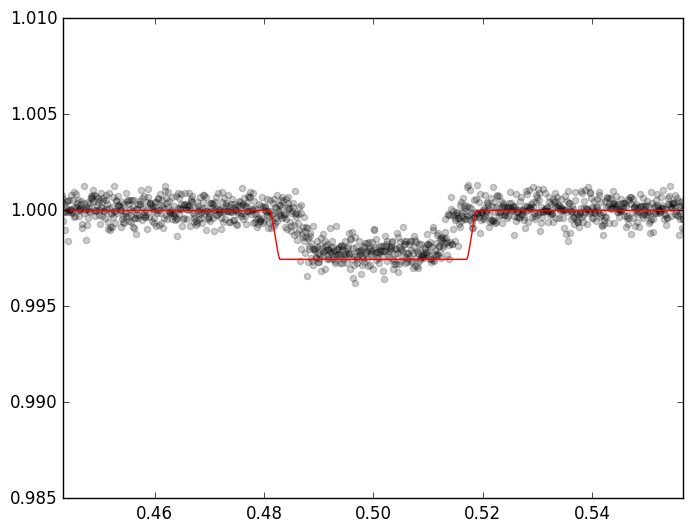

In [27]:
plot_transit(times,flux0,result);

In [28]:
#Calculates the density of the star based on the fit!
function density(x_data::Array{Float64},fit::LsqFit.LsqFitResult{Float64})
    Msun = 1.9891e33  # g
    Rsun = 6.955e10   # cm
    
    P = fit.param[4]+0.19
    T = fit.param[5]
    F0 = fit.param[1]
    y_fit = transit(x_data,fit.param)/F0
    b = fit.param[7]*Rsun
    dflux = maximum(1.0-y_fit)
    
    # factor to put it in units of sun
    factor = (365.25^2.0/215.^3.0)*(Msun / Rsun^3.0)
    rho = (factor/P^2.0) * ((1+sqrt(dflux))^2.0 -(b^2.0*(1-(sinpi(T/P))^2.0))/(sinpi(T/P)^2.0))^1.5
    return rho
end

density (generic function with 1 method)

In [35]:
foo = density(times,result)
println("Density = $foo g/cm^3")

Density = 0.0006020179209933032 g/cm^3


In [37]:
for (par,val) in zip(["F_0";"k";"l";"P";"T";"t_n";"b"],result.param)
    println("$par = $val")
end

F_0 = 22933.148317245374
k = 3.5119477157800837e9
l = 6.960000000000008e10
P = 12.17172572060357
T = 0.4601862920775658
t_n = 12.984198514708178
b = 0.0
